In [5]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

root_dir = '/media/ssd_2tb_evo/DL_based_wind_profile_estimation'
sys.path.append(root_dir)
from libraries import *
from plotters import *

# === gather variables provided as input arguments ===
config_file = 'config_CERRA_to_CERRA.yaml' #sys.argv[1]
train_years = int(17) #int(sys.argv[2])
Ens = 0 #int(sys.argv[3]) #ensemble number

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
input_file = config['input_file']
input_times_freq = config['input_times_freq']
Coeff_file = config['Coeff_file']
profiles_file = None if config['profiles_file'] == '' else config['profiles_file']
input_variables = config['input_variables']
train_locations = config['train_locations']
test_dates_range = config['test_dates_range']
test_locations = config['test_locations']
nEns = config['nEns']
tabnet_param_file = config['tabnet_param_file']
target_variables = config['target_variables']
experiment = config['experiment']

In [38]:
# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2017-10-17T03:00:00','2017-06-06T10:00:00'],
                'Low shear/well mixed':['2017-05-10T12:00:00','2017-11-20T13:00:00'],
                'LLJ': ['2018-04-10T03:00:00','2017-03-30T02:00:00'],
                'High wind': ['2017-12-31T12:00:00','2018-01-05T04:00:00'],
                }
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]

In [12]:
for run,year in enumerate(np.arange(2000,2017+1-train_years)):
    train_dates_range = [str(year)+'-01-01',str(year+train_years-1)+'-12-31']
    print(run,train_dates_range)

    # === training and validation data parameters ===#
    X_train,Y_train, X_valid,Y_valid = data_processing(input_file,Coeff_file,input_times_freq,
                                                       input_variables,target_variables,train_dates_range,train_locations,val_arg=True,
                                                       profiles_file=profiles_file,threshold=2)
    print('training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape,'validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)

0 ['2000-01-01', '2016-12-31']
training inputs shape: (358992, 14) training targets shape: (358992, 5) validation inputs shape: (88128, 14) validation targets shape: (88128, 5)


In [4]:
import pandas as pd

# Define the start and end dates
start_date = pd.Timestamp('2000-01-01')
end_date = pd.Timestamp('2016-12-31')

# Calculate the number of hours between the dates
hours_between = (end_date - start_date).total_seconds() / 3600

print("Number of hours between 2000 Jan 1 and 2016 Dec 31:", hours_between)


Number of hours between 2000 Jan 1 and 2016 Dec 31: 149016.0


In [4]:
# === testing data parameters ===#
X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

testing inputs shape: (3072, 14) testing targets shape: (3072, 5)


In [12]:
df_Obs = pd.read_csv('../data/Heligoland_wind.csv',index_col=0,parse_dates=True)
df_Obs = df_Obs.resample('H').mean()
print('Observed data shape including missing values:',df_Obs.shape)
print('Observed data shape excluding missing values:',df_Obs.dropna().shape) 

Observed data shape including missing values: (9228, 24)
Observed data shape excluding missing values: (7026, 24)


In [23]:
obs_levels = [40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 450, 500]
CERRA_levels = [10., 15., 30., 50., 75., 100., 150., 200., 250., 300., 400., 500.]
ERA5_levels = [10, 100]
def profle_plotter(fig,gs,X_test,Y_test,ERA5_ws=None,Obs=None,date=None,title=None,xlabel=None,ylabel=None,train_years=None,run=None,experiment=experiment):
    axs = fig.add_subplot(gs)
    
    # plot ERA5 10m and 100m wind speeds
    ERA5_ws = X_test[0,0:2] if ERA5_ws is None else ERA5_ws
    axs.plot(ERA5_ws, ERA5_levels, 'dg', markerfacecolor='g', label='ERA5')

    # Calculate observed profile
    M_true = WindProfile(Z, Y_test[0,:])
    axs.plot(M_true, Z, '-k', linewidth=2, markerfacecolor='r', label='CERRA')

    if Obs is not None:
        axs.plot(Obs,obs_levels, '--r', linewidth=2, markerfacecolor='r',label='Obs')
    
    # Initialize arrays to store ensemble predictions
    ensemble_predictions = np.zeros((10, len(Z)))

    for j, Ens in enumerate(np.arange(10)):
        OUTPUT_DIR = f'trained_models/{experiment}/{train_years}Y/run_{run}/Ens_{Ens}'

        # Load normalizer
        min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')

        # Load model
        fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
        print(fSTR)
        with open(fSTR, "rb") as f:
            tabReg = pickle.load(f)
            Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X_test))
        Mp = WindProfile(Z, Y_pred[0, :])
        # Store ensemble predictions
        ensemble_predictions[j, :] = Mp

    # Calculate percentiles
    median_profile = np.median(ensemble_predictions, axis=0)
    p25_profile = np.percentile(ensemble_predictions, 25, axis=0)
    p75_profile = np.percentile(ensemble_predictions, 75, axis=0)
    p5_profile = np.percentile(ensemble_predictions, 10, axis=0)
    p95_profile = np.percentile(ensemble_predictions, 90, axis=0)

    # Plot median
    axs.plot(median_profile, Z, linestyle='-', linewidth=2, label='Ensemble (p50)')

    # Plot shaded regions
    axs.fill_betweenx(Z, p25_profile, p75_profile, color='gray', alpha=0.5, label='Ensemble (p25-p75)')
    axs.fill_betweenx(Z, p5_profile, p95_profile, color='gray', alpha=0.3, label='Ensemble (p10-p90)')

    axs.set_xlim([0, 30])
    axs.set_ylim([0, 500])

    if title is not None:
        axs.set_title(title)

    if xlabel is not None:
        axs.set_xlabel(xlabel)
    if not xlabel:
        axs.xaxis.set_ticks([])
    
    if ylabel is not None:
        axs.set_ylabel(ylabel)
    if not ylabel:
        axs.yaxis.set_ticks([])
    
    return axs

0 High shear 2017-10-17T02:00:00
0 Low shear/well mixed 2017-05-10T12:00:00
0 LLJ 2018-04-10T02:00:00
0 High wind 2017-12-31T11:00:00
1 High shear 2017-10-17T02:00:00
1 Low shear/well mixed 2017-05-10T12:00:00
1 LLJ 2018-04-10T02:00:00
1 High wind 2017-12-31T11:00:00
2 High shear 2017-10-17T02:00:00
2 Low shear/well mixed 2017-05-10T12:00:00
2 LLJ 2018-04-10T02:00:00
2 High wind 2017-12-31T11:00:00
3 High shear 2017-10-17T02:00:00
3 Low shear/well mixed 2017-05-10T12:00:00
3 LLJ 2018-04-10T02:00:00
3 High wind 2017-12-31T11:00:00
4 High shear 2017-10-17T02:00:00
4 Low shear/well mixed 2017-05-10T12:00:00
4 LLJ 2018-04-10T02:00:00
4 High wind 2017-12-31T11:00:00


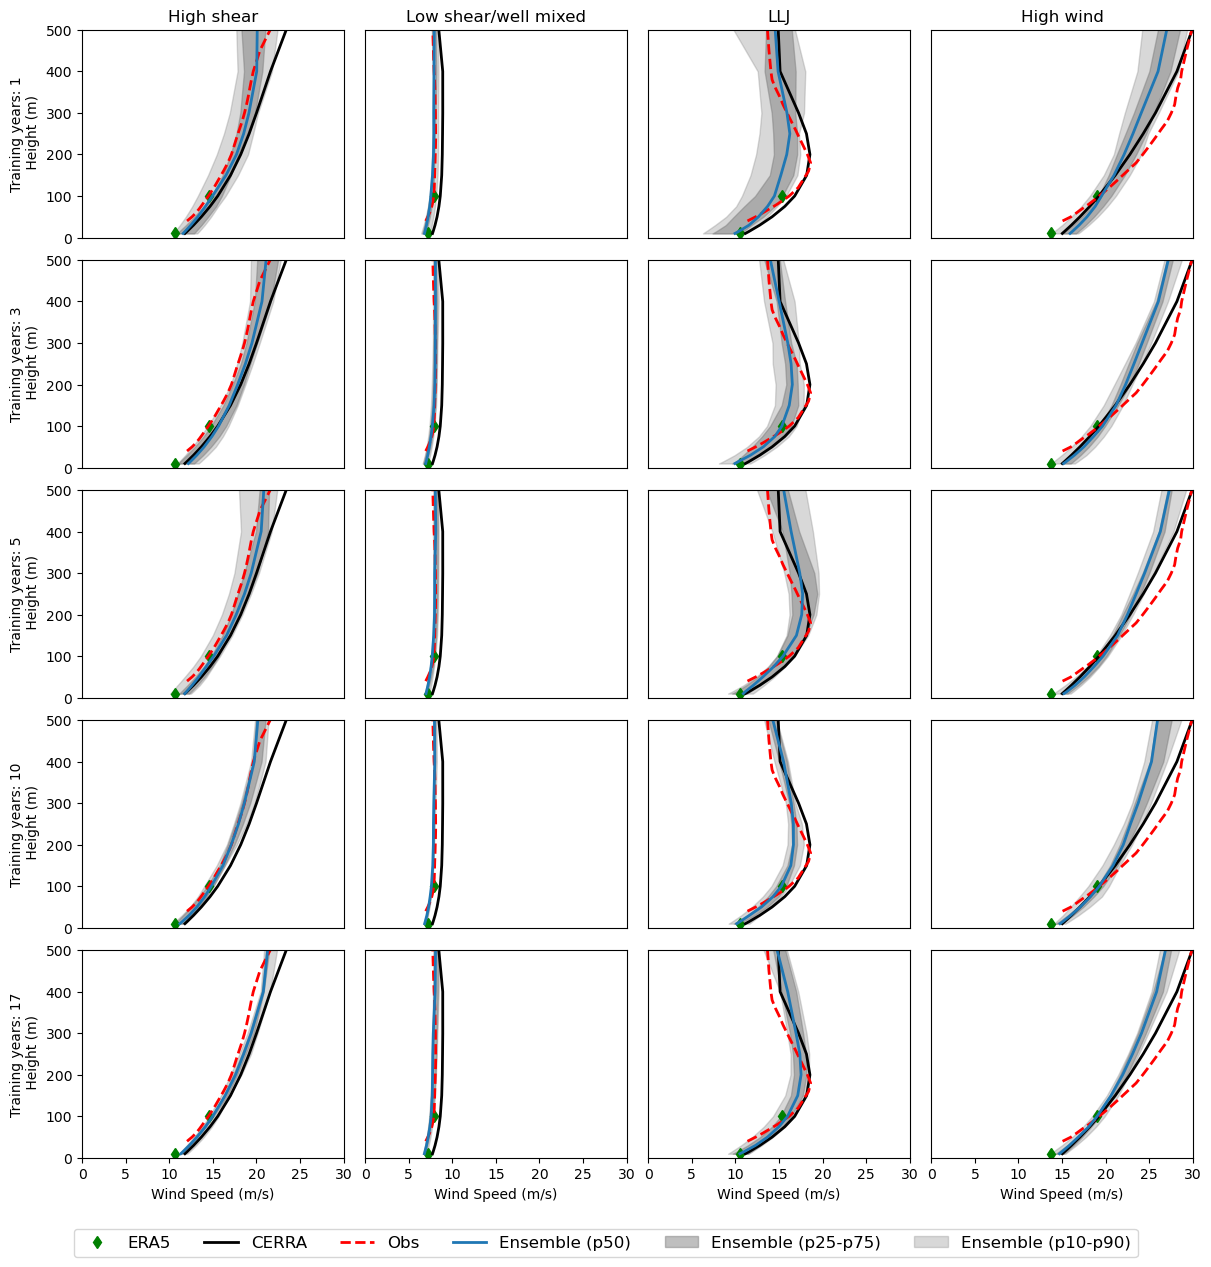

In [65]:
train_years = [1,3,5,10,17]
run = 0
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(5,4)
for i,train_year in enumerate(train_years):
    for k,profile in enumerate(profile_dates):
        print(i,profile, profile_dates[profile][0])

        X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
        Obs = df_Obs[profile_dates[profile][0]:profile_dates[profile][0]].values.T

        title = profile if i == 0 else None
        xlabel = f'Wind Speed (m/s)' if i == 4 else None
        ylabel = f'Training years: {train_year}\n Height (m)' if k == 0 else None
        axs = profle_plotter(fig,gs[i,k],X_test,Y_test,Obs=Obs,title=title,xlabel=xlabel,ylabel=ylabel,train_years=train_year,run=run)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05),fontsize=12)

plt.savefig(f'Figures/Tabnet_multioutput_{experiment}_best_wind_profiles_sensitivity_wrt_training_size.pdf',dpi=300,bbox_inches='tight',pad_inches=0)

0 High shear 2017-10-17T02:00:00
0 Low shear/well mixed 2017-05-10T12:00:00
0 LLJ 2018-04-10T02:00:00
0 High wind 2017-12-31T11:00:00
1 High shear 2017-10-17T02:00:00
1 Low shear/well mixed 2017-05-10T12:00:00
1 LLJ 2018-04-10T02:00:00
1 High wind 2017-12-31T11:00:00
2 High shear 2017-10-17T02:00:00
2 Low shear/well mixed 2017-05-10T12:00:00
2 LLJ 2018-04-10T02:00:00
2 High wind 2017-12-31T11:00:00
3 High shear 2017-10-17T02:00:00
3 Low shear/well mixed 2017-05-10T12:00:00
3 LLJ 2018-04-10T02:00:00
3 High wind 2017-12-31T11:00:00
4 High shear 2017-10-17T02:00:00
4 Low shear/well mixed 2017-05-10T12:00:00
4 LLJ 2018-04-10T02:00:00
4 High wind 2017-12-31T11:00:00


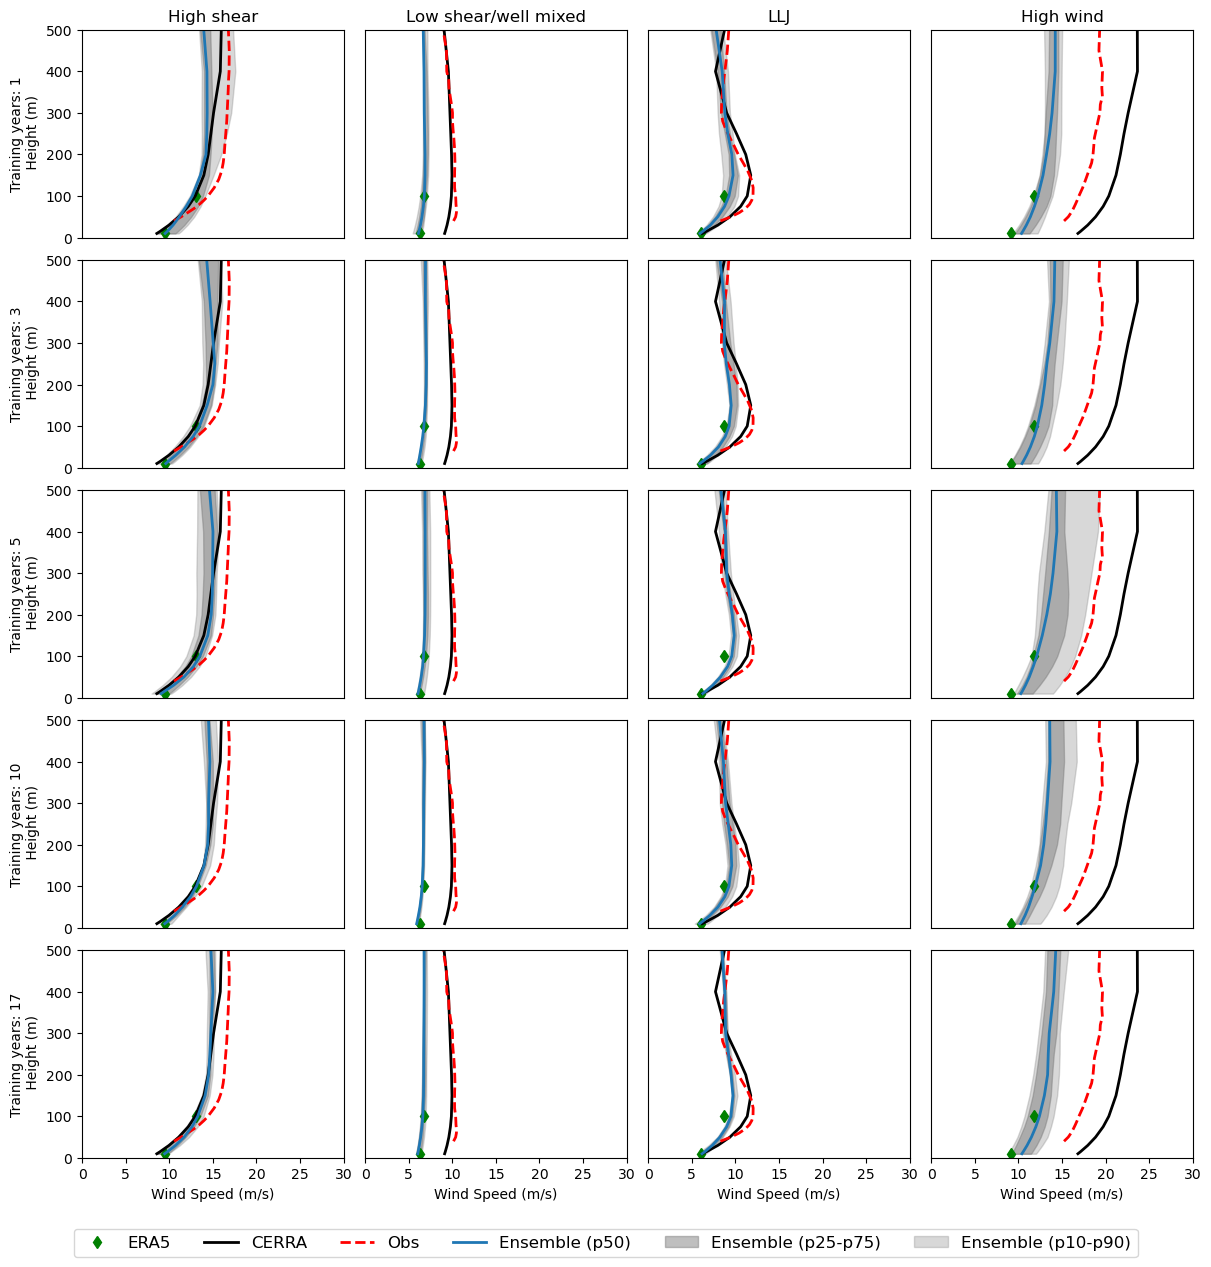

In [66]:
train_years = [1,3,5,10,17]
run = 0
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(5,4)
for i,train_year in enumerate(train_years):
    for k,profile in enumerate(profile_dates):
        print(i,profile, profile_dates[profile][0])

        X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
        Obs = df_Obs[profile_dates[profile][1]:profile_dates[profile][1]].values.T

        title = profile if i == 0 else None
        xlabel = f'Wind Speed (m/s)' if i == 4 else None
        ylabel = f'Training years: {train_year}\n Height (m)' if k == 0 else None
        axs = profle_plotter(fig,gs[i,k],X_test,Y_test,Obs=Obs,title=title,xlabel=xlabel,ylabel=ylabel,train_years=train_year,run=run)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05),fontsize=12)

plt.savefig(f'Figures/Tabnet_multioutput_{experiment}_worst_wind_profiles_sensitivity_wrt_training_size.pdf',dpi=300,bbox_inches='tight',pad_inches=0)

# Checking the ML model trained on CERRA-to-CERRA, providing same CERRA inputs

In [34]:
# === gather variables provided as input arguments ===
config_file = 'config_CERRA_to_CERRA.yaml' #sys.argv[1]

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
input_file = config['input_file']
input_times_freq = config['input_times_freq']
Coeff_file = config['Coeff_file']
input_variables = config['input_variables']
train_locations = config['train_locations']
test_dates_range = config['test_dates_range']
test_locations = config['test_locations']
nEns = config['nEns']
tabnet_param_file = config['tabnet_param_file']
target_variables = config['target_variables']
experiment = config['experiment']

X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

testing inputs shape: (3072, 14) testing targets shape: (3072, 5)


0 High shear 2017-10-17T03:00:00
(1, 14) (1, 5) (2,)
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_0/TabNet_HOLDOUT_Ens_0.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_1/TabNet_HOLDOUT_Ens_1.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_2/TabNet_HOLDOUT_Ens_2.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_3/TabNet_HOLDOUT_Ens_3.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_4/TabNet_HOLDOUT_Ens_4.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_5/TabNet_HOLDOUT_Ens_5.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_6/TabNet_HOLDOUT_Ens_6.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_7/TabNet_HOLDOUT_Ens_7.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_8/TabNet_HOLDOUT_Ens_8.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_9/TabNet_HOLDOUT_Ens_9.pkl
0 Low shear/well mixed 2017-05-10T12:00:00
(1, 14) (1, 5) (2,)
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_0/TabNet_HOLDOUT_Ens_0.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_1/TabNet_HOLDOUT_Ens_1.pkl
trained_models/CERRA_to_CERRA/17

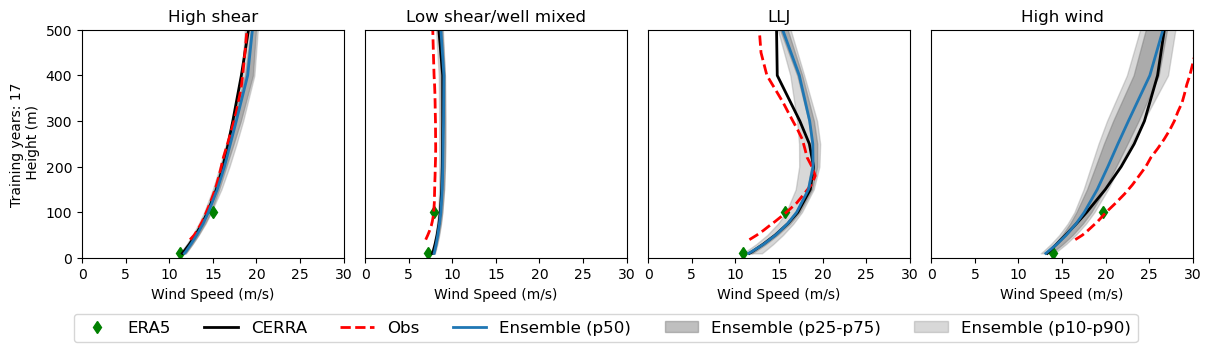

In [39]:
train_years = [17]
run = 0
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)
for i,train_year in enumerate(train_years):
    for k,profile in enumerate(profile_dates):
        print(i,profile, profile_dates[profile][0])

        X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
        ERA5_input_file = '/media/ssd_2tb_evo/DL_based_wind_profile_estimation/data/ERA5.nc'
        ERA5_ws, _ = data_processing(ERA5_input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
        ERA5_ws = ERA5_ws[0,0:2]
        print(X_test.shape,Y_test.shape,ERA5_ws.shape)
        
        Obs = df_Obs[profile_dates[profile][0]:profile_dates[profile][0]].values.T

        title = profile if i == 0 else None
        xlabel = f'Wind Speed (m/s)' #if i == 4 else None
        ylabel = f'Training years: {train_year}\n Height (m)' if k == 0 else None
        axs = profle_plotter(fig,gs[i,k],X_test,Y_test,ERA5_ws=ERA5_ws,Obs=Obs,title=title,xlabel=xlabel,ylabel=ylabel,train_years=train_year,run=run)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)

plt.savefig(f'Figures/Tabnet_multioutput_{experiment}_best_wind_profiles_CERRA-to-CERRA_model_with_CERRA_inputs.pdf',dpi=300,bbox_inches='tight',pad_inches=0)

# Checking ML model trained on CERRA-to-CERRA, provided ERA5 inputs now

In [40]:
# === gather variables provided as input arguments ===
config_file = 'config_CERRA_to_CERRA.yaml' #sys.argv[1]

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
input_file = config['input_file']
input_times_freq = config['input_times_freq']
Coeff_file = config['Coeff_file']
input_variables = config['input_variables']
train_locations = config['train_locations']
test_dates_range = config['test_dates_range']
test_locations = config['test_locations']
nEns = config['nEns']
tabnet_param_file = config['tabnet_param_file']
target_variables = config['target_variables']
experiment = config['experiment']

# === testing data parameters ===#
input_file = '/media/ssd_2tb_evo/DL_based_wind_profile_estimation/data/ERA5.nc'
input_times_freq = 1
X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

testing inputs shape: (9216, 14) testing targets shape: (9216, 5)


0 High shear 2017-10-17T03:00:00
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_0/TabNet_HOLDOUT_Ens_0.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_1/TabNet_HOLDOUT_Ens_1.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_2/TabNet_HOLDOUT_Ens_2.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_3/TabNet_HOLDOUT_Ens_3.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_4/TabNet_HOLDOUT_Ens_4.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_5/TabNet_HOLDOUT_Ens_5.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_6/TabNet_HOLDOUT_Ens_6.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_7/TabNet_HOLDOUT_Ens_7.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_8/TabNet_HOLDOUT_Ens_8.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_9/TabNet_HOLDOUT_Ens_9.pkl
0 Low shear/well mixed 2017-05-10T12:00:00
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_0/TabNet_HOLDOUT_Ens_0.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_1/TabNet_HOLDOUT_Ens_1.pkl
trained_models/CERRA_to_CERRA/17Y/run_0/Ens_2/TabNet_HOLDOUT_Ens_2.pkl
t

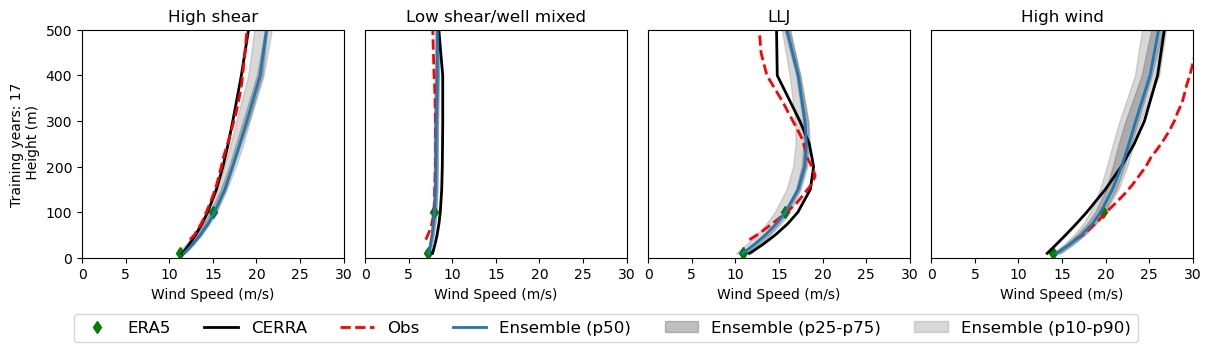

In [41]:
train_years = [17]
run = 0
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)
for i,train_year in enumerate(train_years):
    for k,profile in enumerate(profile_dates):
        print(i,profile, profile_dates[profile][0])

        X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
        Obs = df_Obs[profile_dates[profile][0]:profile_dates[profile][0]].values.T

        title = profile if i == 0 else None
        xlabel = f'Wind Speed (m/s)' #if i == 4 else None
        ylabel = f'Training years: {train_year}\n Height (m)' if k == 0 else None
        axs = profle_plotter(fig,gs[i,k],X_test,Y_test,Obs=Obs,title=title,xlabel=xlabel,ylabel=ylabel,train_years=train_year,run=run)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)

plt.savefig(f'Figures/Tabnet_multioutput_{experiment}_best_wind_profiles_CERRA-to-CERRA_model_with_ERA5_inputs.pdf',dpi=300,bbox_inches='tight',pad_inches=0)